Se importan las librerias 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy 
from numpy import fft
import math as mt

data = [[1, 2, 3],[4, 5, 6], [7, 8, 9], [10, 11, 12], [13, 14, 15], [16, 17, 18], [19, 20, 21],[22, 23, 24],[25, 26, 27],[28, 29, 30]] 
df = pd.DataFrame(data) 
nuevas_filas = ['Potencia activa (P), [W]'          ,          
                'Potencia reactiva (Q), [var]'      ,      
                'Potencia armónica (D), [VA]'       ,       
                'Potencia aparente (S), [VA]'       ,       
                'Factor de desplazamiento (DPF)'    ,    
                'Factor de distorsión (DP)'         ,         
                'Factor de potencia (PF)'           ,           
                'THD de corriente (THD)'            ,            
                'Factor de cresta de corriente (CF)',
                'Factor de forma de corriente (FF)' ] 
nuevas_columnas = ['Cautín', 'Ventilador', 'Cargador de laptop']
df.columns = nuevas_columnas
df.index = nuevas_filas 

def get_oscilloscope(ruta):
    Dataframe = pd.read_csv(ruta)
    Dataframe = Dataframe.iloc[:, 3:5] 
    Dataframe.columns = ["Tiempo", "Magnitud"]
    return Dataframe 

def filtro(signal, time, fc):

    fourier = np.fft.fft(signal)
    freq = np.fft.fftfreq(len(signal), d=time[1] - time[0])
    fourier_filt = fourier.copy()
    fourier_filt[np.abs(freq) > fc] = 0
    signal_filt = np.fft.ifft(fourier_filt)    
    return np.real(signal_filt)

def Armonicos(señal, tiempo, n):
    T = len(tiempo)
    an = 0
    bn = 0
    a0 = 0
    for i in range (0,T,1):
        a0 += (1/T) * señal[i]
        an += (2/T) * señal[i]*np.cos(n*2*np.pi*60*tiempo[i])
        bn += (2/T) * señal[i]*np.sin(n*2*np.pi*60*tiempo[i])
    An = np.sqrt((an**2) + (bn**2))
    theta_n = np.arctan(bn/an)
    gamma_n = np.arctan(an/bn)
    return An, theta_n, gamma_n, a0, an, bn

def buscaarmonicos(magnitud, tiempo):
    n = 50
    armonicos = np.zeros(n)
    thetas = np.zeros(n)
    gammas = np.zeros(n)
    an = np.zeros(n)
    bn = np.zeros(n)
    RMS = np.zeros(n)
    ft = 0
    for j in range(1,n,1):
        armonicos[j] ,thetas[j], gammas[j], a0, an[j], bn[j]  = Armonicos(magnitud,tiempo,j)
        RMS[j] = np.sqrt(np.mean(np.square(an[j]*np.cos(j*2*np.pi*60*tiempo) + bn[j]*np.sin(j*2*np.pi*60*tiempo))))
        ft += an[j]*np.cos(j*2*np.pi*60*tiempo) + bn[j]*np.sin(j*2*np.pi*60*tiempo)
    RMS[0] = a0
    RMS_ARMONICOS = RMS    
    ft = ft + a0
    return ft, armonicos , RMS_ARMONICOS 

def promedio(fun,tiempo,n):
    T=len(tiempo)
    Prom = 0
    for i in range(T):
        Prom += abs(fun[i])
    Prom = Prom/T
    Prom = Prom/n
    return Prom

def THD(RMS, RMST):
    THDi = (np.sqrt(RMST**2 - RMS[1]**2))/(RMS[1])
    return THDi

def lht(CH1,CH2,R,X,XX,df):

    tiempo=CH1.Tiempo
    CURRENT=(CH1.Magnitud-CH2.Magnitud)/R
    CURRENT=filtro(CURRENT, tiempo.to_numpy(),3500)

    ft, armonicos, RMS_Armonicos =buscaarmonicos(CURRENT, tiempo)
    
    plt.stem(armonicos)
    plt.title("Ármonicos para la señal del " + str(X) + " " +str(XX))
    plt.xlabel("Número de armónico [n]")
    plt.ylabel("Amplitud [A]")
    plt.grid()
    plt.show()

    plt.plot(tiempo,ft,label='Señal reconstruida')
    plt.plot(tiempo,CURRENT,label='Señal hallada con las medidas')
    plt.title("Corriente del " + str(X))
    plt.xlabel("Tiempo [s]")
    plt.ylabel("Amplitud [A]")
    plt.legend()
    plt.grid()
    plt.show()

    INST_POWER=CH1.Magnitud*CURRENT
    plt.plot(tiempo, INST_POWER)
    plt.title("Potencia instantánea del " + str(X))
    plt.xlabel("Tiempo [s]")
    plt.ylabel("Amplitud [VA]")
    plt.grid()
    plt.show()

    RMST = (np.sqrt(np.sum(RMS_Armonicos**2)))
    THDi = THD(RMS_Armonicos,RMST)
    p_ave = np.mean(CH1.Magnitud*CURRENT)

    v_RMS = np.sqrt(np.mean(np.square(CH1.Magnitud)))
    CURRENT_RMS = np.sqrt(np.mean(np.square(CURRENT)))

    S_aparente = CURRENT_RMS*v_RMS

    pruebarms = promedio(ft,tiempo,1)
    CF_v, CF_i = max(CH1.Magnitud)/v_RMS,max(CURRENT)/CURRENT_RMS
    FF_v, FF_i = v_RMS/((abs(CH1.Magnitud[0])+max(CH1.Magnitud))/2), CURRENT_RMS/(pruebarms)

    DP = 1/np.sqrt(1+(THDi**2))
    FP = p_ave/S_aparente
    phi = np.arccos(FP/DP)
    Q = v_RMS*RMS_Armonicos[1]*np.sin(phi)
    D = np.sqrt((S_aparente**2)-(p_ave**2)-(Q**2))

    print(f'La potencia activa del {X} es {p_ave} W')
    print(f'la potencia reactiva del {X} es {Q} VAR')
    print(f'La potencia aparente del {X} es {S_aparente} VA')
    print(f'la potencia armonica del {X} es {D} VA')
    print("-------------------------------")
    
    #print(f'El factor de rizado de voltaje es de  {CF_v}')
    print(f'El factor de rizado de corriente es de {CF_i}')
    #print(f'El factor de forma de voltaje es de  {FF_v}')
    print(f'El factor de forma de corriente es de {FF_i}')

    print("-------------------------------")
    print(f'El factor de potencia PF es {FP}')
    print(f'El factor de desplazamiento DPF {FP/DP}')
    print(f'El factor de distorsion DP {DP}')
    print(f'El THD es de {THDi} de la corriente del {X}')

    df.at['Potencia activa (P), [W]'          , X] = p_ave
    df.at['Potencia reactiva (Q), [var]'      , X] = Q
    df.at['Potencia armónica (D), [VA]'       , X] = D
    df.at['Potencia aparente (S), [VA]'       , X] = S_aparente
    df.at['Factor de desplazamiento (DPF)'    , X] = FP/DP
    df.at['Factor de distorsión (DP)'         , X] = DP
    df.at['Factor de potencia (PF)'           , X] = FP
    df.at['THD de corriente (THD)'            , X] = THDi
    df.at['Factor de cresta de corriente (CF)', X] = CF_i
    df.at['Factor de forma de corriente (FF)' , X] = FF_i


Carga inductiva

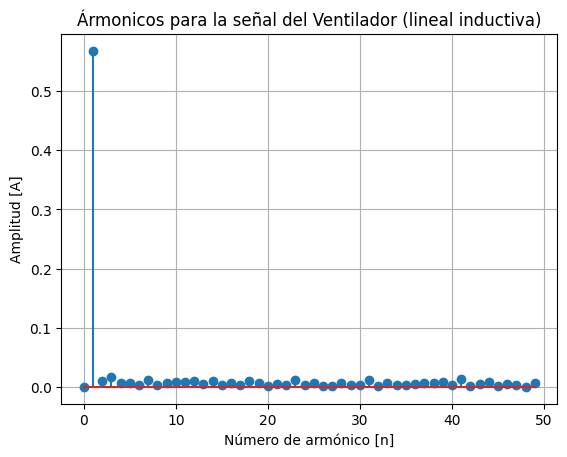

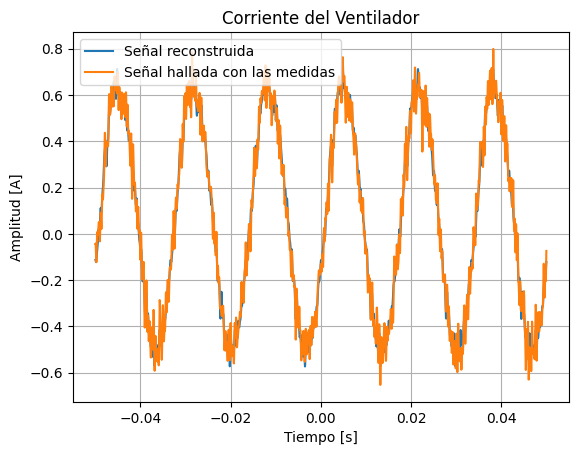

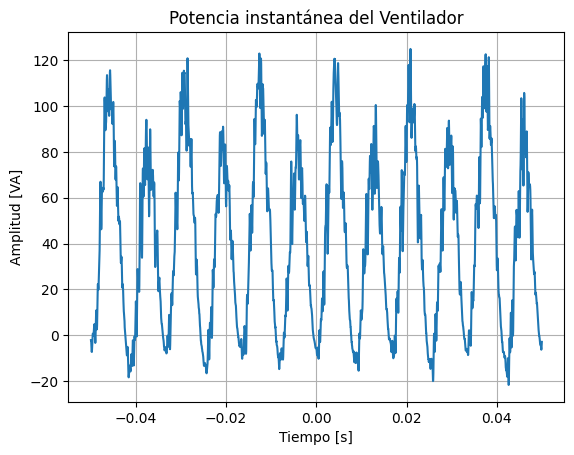

La potencia activa del Ventilador es 40.79534813910406 W
la potencia reactiva del Ventilador es 28.667009090110913 VAR
La potencia aparente del Ventilador es 50.790786475116036 VA
la potencia armonica del Ventilador es 9.677094129831929 VA
-------------------------------
El factor de rizado de corriente es de 1.944768793577635
El factor de forma de corriente es de 1.1291092484942296
-------------------------------
El factor de potencia PF es 0.8032037101668222
El factor de desplazamiento DPF 0.8165069901629944
El factor de distorsion DP 0.9837070837648108
El THD es de 0.18275631208383997 de la corriente del Ventilador


In [2]:
CH1=get_oscilloscope("abanico/CH1.CSV")#Tension en el canal 1/2
CH2=get_oscilloscope("abanico/CH2.CSV")
R=10.4
X='Ventilador'
XX='(lineal inductiva)'
lht(CH1,CH2,R,X,XX,df)

## Carga no lineal

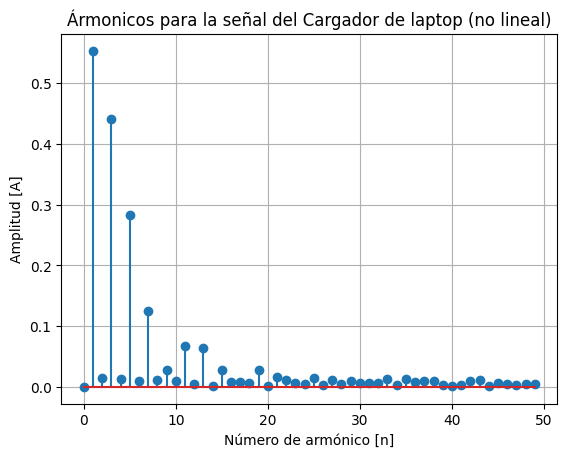

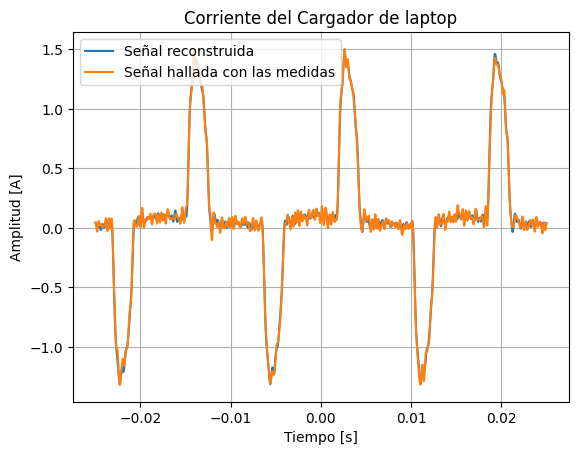

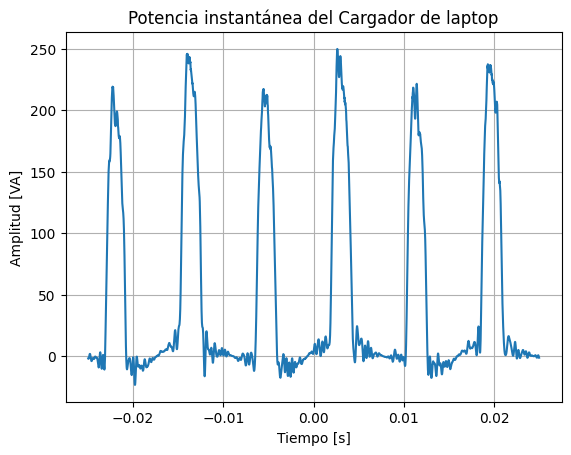

La potencia activa del Cargador de laptop es 47.079517400473726 W
la potencia reactiva del Cargador de laptop es 12.045375038112509 VAR
La potencia aparente del Cargador de laptop es 69.12185278162954 VA
la potencia armonica del Cargador de laptop es 49.15545253067024 VA
-------------------------------
El factor de rizado de corriente es de 2.702620568866948
El factor de forma de corriente es de 1.736756101610534
-------------------------------
El factor de potencia PF es 0.6811090198812786
El factor de desplazamiento DPF 0.9687175347078391
El factor de distorsion DP 0.7031038413965512
El THD es de 1.0113544339030736 de la corriente del Cargador de laptop


In [3]:
CH1=get_oscilloscope("PC\ALL0001\F0001CH1.CSV")#Tension en el canal 1/2
CH2=get_oscilloscope("PC\ALL0001\F0001CH2.CSV")
R=10.4
X='Cargador de laptop'
XX='(no lineal)'
o=3
lht(CH1,CH2,R,X,XX,df)

CARGA RESISTIVA

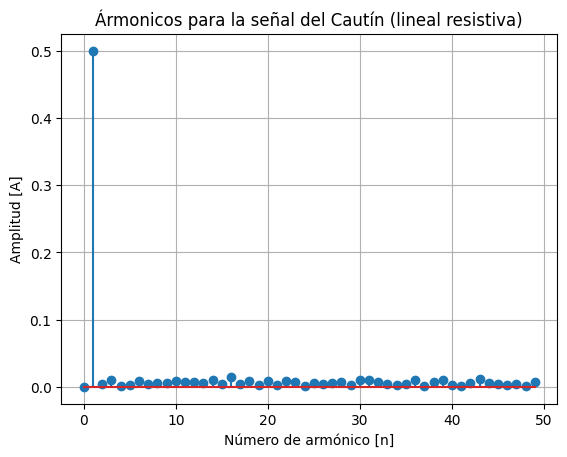

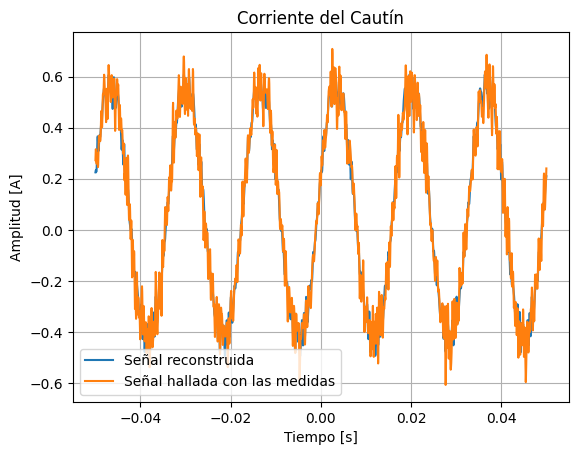

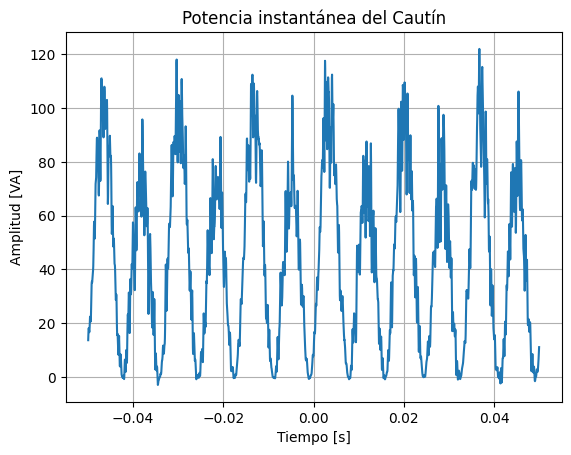

La potencia activa del Cautín es 44.023916413418 W
la potencia reactiva del Cautín es 5.471262551284172 VAR
La potencia aparente del Cautín es 45.3198663809919 VA
la potencia armonica del Cautín es 9.265546854355653 VA
-------------------------------
El factor de rizado de corriente es de 1.9470058068090124
El factor de forma de corriente es de 1.1279716361983778
-------------------------------
El factor de potencia PF es 0.9714043735990041
El factor de desplazamiento DPF 0.9922351532614495
El factor de distorsion DP 0.9790062067505115
El THD es de 0.2082013738328888 de la corriente del Cautín


In [4]:
CH1=get_oscilloscope("cautin\F0000CH1.CSV")#Tension en el canal 1/2
CH2=get_oscilloscope("cautin\F0000CH2.CSV")
R=10.4
X='Cautín'
XX='(lineal resistiva)'
o=1
lht(CH1,CH2,R,X,XX,df)

### <span style="color:red">RESUMEN DE LOS RESULTADOS</span>

In [6]:
df.round(2)

,Cautín,Ventilador,Cargador de laptop
"Potencia activa (P), [W]",44.02,40.80,47.08
"Potencia reactiva (Q), [var]",5.47,28.67,12.05
"Potencia armónica (D), [VA]",9.27,9.68,49.16
"Potencia aparente (S), [VA]",45.32,50.79,69.12
Factor de desplazamiento (DPF),0.99,0.82,0.97
Factor de distorsión (DP),0.98,0.98,0.70
Factor de potencia (PF),0.97,0.80,0.68
THD de corriente (THD),0.21,0.18,1.01
Factor de cresta de corriente (CF),1.95,1.94,2.70
Factor de forma de corriente (FF),1.13,1.13,1.74
